In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/archive.zip"
extract_path = "/content/archive"  # ممكن تغيّر الاسم

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model


In [ ]:
train_dir = "/content/archive/train/"
test_dir = "/content/archive/test/"



row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       fear   sad  neutral  angry  disgust  surprise  happy
train  4097  4830     4965   3995      436      3171   7215
      fear   sad  neutral  angry  disgust  surprise  happy
test  1024  1247     1233    958      111       831   1774


<Axes: >

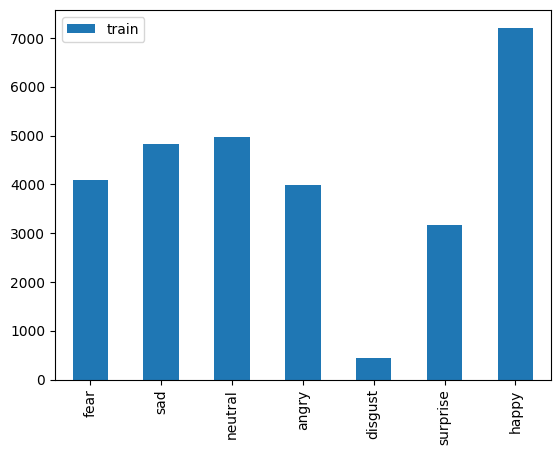

In [ ]:
train_count.transpose().plot(kind='bar')

<Axes: >

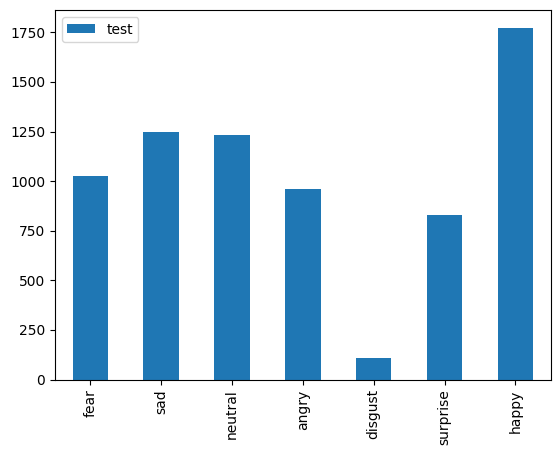

In [ ]:
test_count.transpose().plot(kind='bar')

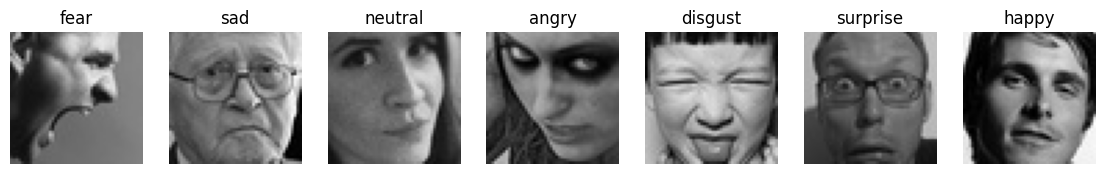

In [ ]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

In [ ]:
train_datagen = ImageDataGenerator( rescale=1./255,
    zoom_range=0.3,
    horizontal_flip=True,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    shear_range=0.2,
    fill_mode='nearest')

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [ ]:
def get_model(input_size, classes=7):
    # Initialising the CNN
    model = tf.keras.models.Sequential()

    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.6))

    model.add(Dense(classes, activation='softmax'))

    # Compiling the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model




In [ ]:
# استدعاء النموذج:
fernet = get_model((row, col, 1), classes)
fernet.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 22, 22, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    31,720,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,135,495 (122.59 MB)

 Trainable params: 32,134,855 (122.58 MB)

 Non-trainable params: 640 (2.50 KB)

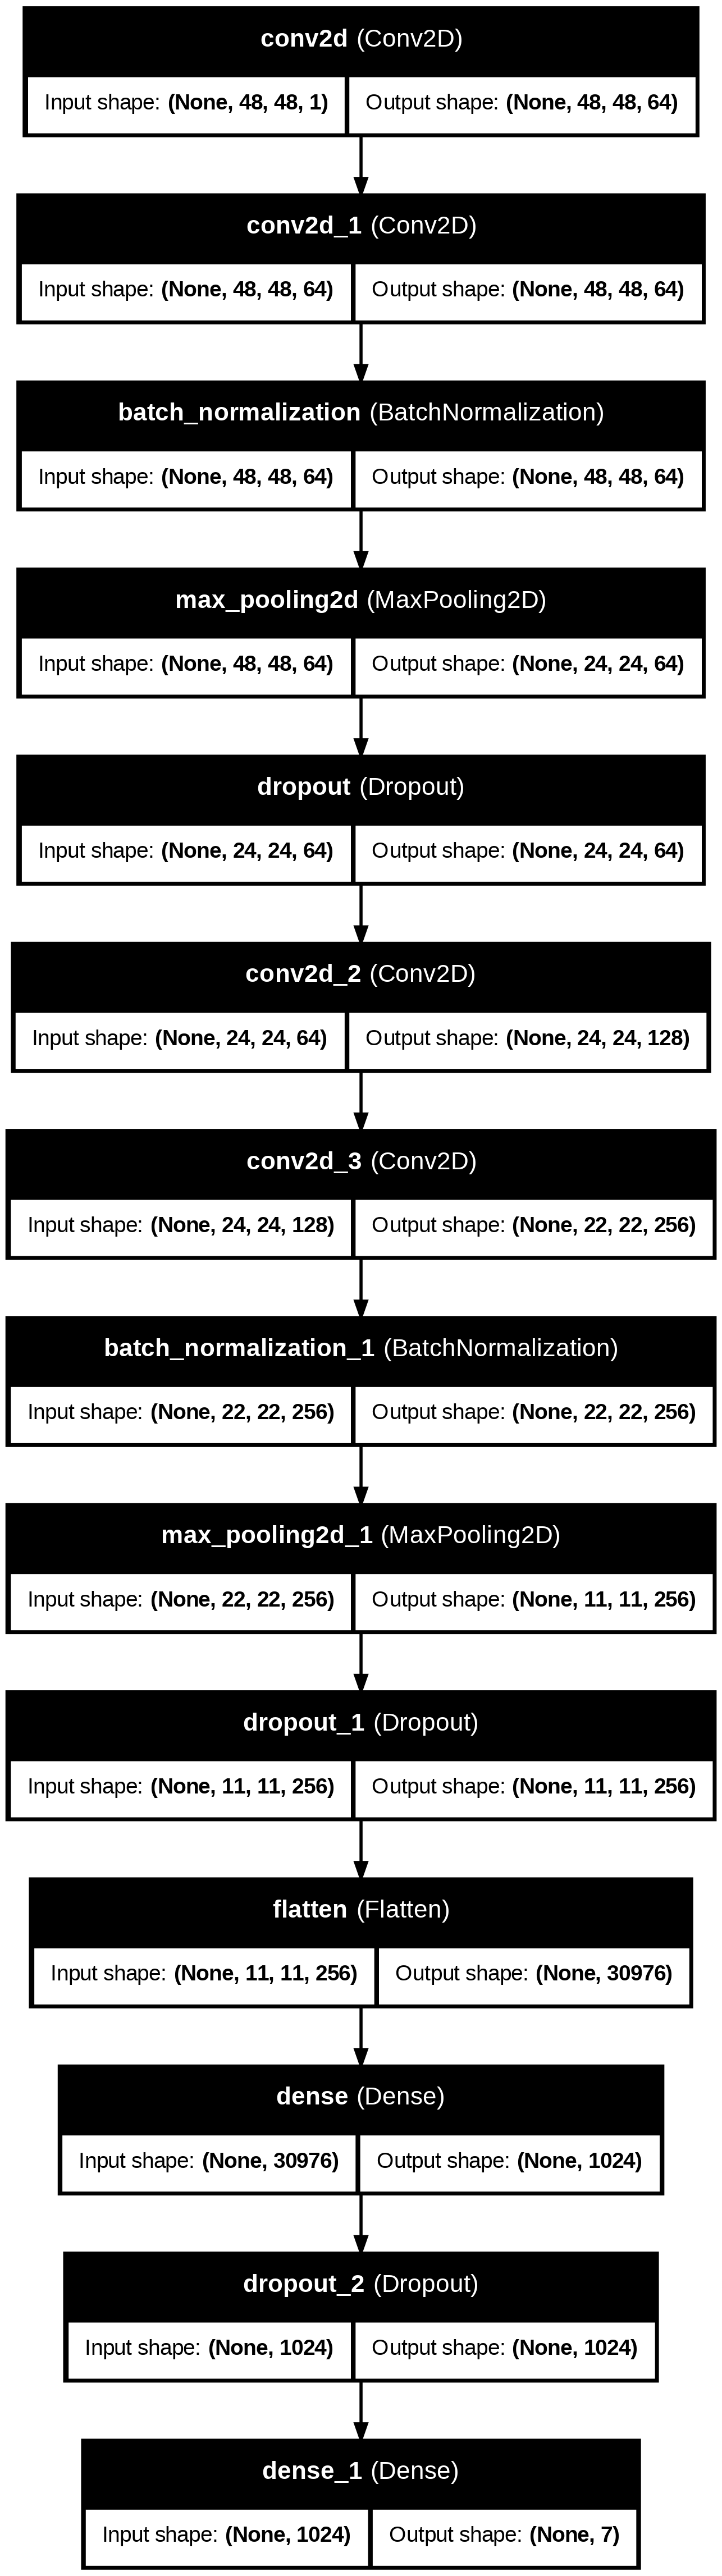

In [ ]:
plot_model(fernet, to_file='fernet.png', show_shapes=True, show_layer_names=True)

In [ ]:
chk_path = 'ferNet.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

In [ ]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet.fit(x=training_set,
                 validation_data=test_set,
                 epochs=60,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.2155 - loss: 5.2432
Epoch 1: val_loss improved from inf to 5.45035, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 54s 96ms/step - accuracy: 0.2155 - loss: 5.2416 - val_accuracy: 0.2559 - val_loss: 5.4504 - learning_rate: 1.0000e-04
Epoch 2/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.2188 - loss: 4.0560

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 5.45035 to 5.44072, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.2188 - loss: 4.0560 - val_accuracy: 0.2561 - val_loss: 5.4407 - learning_rate: 1.0000e-04
Epoch 3/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.2526 - loss: 3.8765
Epoch 3: val_loss improved from 5.44072 to 3.42950, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 36s 80ms/step - accuracy: 0.2526 - loss: 3.8763 - val_accuracy: 0.3290 - val_loss: 3.4295 - learning_rate: 1.0000e-04
Epoch 4/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - accuracy: 0.4062 - loss: 3.4936
Epoch 4: val_loss improved from 3.42950 to 3.42795, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4062 - loss: 3.4936 - val_accuracy: 0.3294 - val_loss: 3.4280 - learning_rate: 1.0000e-04
Epoch 5/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.2592 - loss: 3.4133
Epoch 5: val_loss improved from 3.42795 to 2.99905, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 35s 77ms/step - accuracy: 0.2592 - loss: 3.4131 - val_accuracy: 0.3221 - val_loss: 2.9991 - learning_rate: 1.0000e-04
Epoch 6/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - accuracy: 0.2344 - loss: 3.1842
Epoch 6: val_loss did not improve from 2.99905
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2344 - loss: 3.1842 - val_accuracy: 0.3232 - val_loss: 3.0035 - learning_rate: 1.0000e-04
Epoch 7/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.2777 - loss: 3.0035
Epoch 7: val_loss improved from 2.99905 to 2.61213, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 42s 94ms/step - accuracy: 0.2777 - loss: 3.0032 - val_accuracy: 0.3608 - val_loss: 2.6121 - learning_rate: 1.0000e-04
Epoch 8/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.2812 - loss: 2.6609
Epoch 8: val_loss did not improve from 2.61213
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2812 - loss: 2.6609 - val_accuracy: 0.3636 - val_loss: 2.6134 - learning_rate: 1.0000e-04
Epoch 9/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.2905 - loss: 2.6550
Epoch 9: val_loss improved from 2.61213 to 2.27397, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 72s 77ms/step - accuracy: 0.2905 - loss: 2.6549 - val_accuracy: 0.4056 - val_loss: 2.2740 - learning_rate: 1.0000e-04
Epoch 10/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.3438 - loss: 2.3697
Epoch 10: val_loss improved from 2.27397 to 2.26896, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.3438 - loss: 2.3697 - val_accuracy: 0.4036 - val_loss: 2.2690 - learning_rate: 1.0000e-04
Epoch 11/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.3233 - loss: 2.3575
Epoch 11: val_loss improved from 2.26896 to 2.10374, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 76s 79ms/step - accuracy: 0.3234 - loss: 2.3574 - val_accuracy: 0.3816 - val_loss: 2.1037 - learning_rate: 1.0000e-04
Epoch 12/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 23s 52ms/step - accuracy: 0.3750 - loss: 2.0618
Epoch 12: val_loss did not improve from 2.10374
448/448 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.3750 - loss: 2.0618 - val_accuracy: 0.3768 - val_loss: 2.1189 - learning_rate: 1.0000e-04
Epoch 13/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.3427 - loss: 2.1423
Epoch 13: val_loss improved from 2.10374 to 1.96664, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 44s 99ms/step - accuracy: 0.3428 - loss: 2.1422 - val_accuracy: 0.3958 - val_loss: 1.9666 - learning_rate: 1.0000e-04
Epoch 14/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 23s 53ms/step - accuracy: 0.4375 - loss: 1.9018
Epoch 14: val_loss improved from 1.96664 to 1.96068, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4375 - loss: 1.9018 - val_accuracy: 0.3989 - val_loss: 1.9607 - learning_rate: 1.0000e-04
Epoch 15/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.3681 - loss: 1.9642
Epoch 15: val_loss improved from 1.96068 to 1.67729, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 82s 107ms/step - accuracy: 0.3681 - loss: 1.9641 - val_accuracy: 0.4609 - val_loss: 1.6773 - learning_rate: 1.0000e-04
Epoch 16/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.4219 - loss: 1.7742
Epoch 16: val_loss did not improve from 1.67729
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4219 - loss: 1.7742 - val_accuracy: 0.4576 - val_loss: 1.6820 - learning_rate: 1.0000e-04
Epoch 17/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.3996 - loss: 1.8106
Epoch 17: val_loss improved from 1.67729 to 1.60169, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 43s 95ms/step - accuracy: 0.3996 - loss: 1.8106 - val_accuracy: 0.4664 - val_loss: 1.6017 - learning_rate: 1.0000e-04
Epoch 18/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 23s 52ms/step - accuracy: 0.5000 - loss: 1.6639
Epoch 18: val_loss improved from 1.60169 to 1.58002, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5000 - loss: 1.6639 - val_accuracy: 0.4742 - val_loss: 1.5800 - learning_rate: 1.0000e-04
Epoch 19/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.4266 - loss: 1.6847
Epoch 19: val_loss improved from 1.58002 to 1.52615, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - accuracy: 0.4266 - loss: 1.6846 - val_accuracy: 0.4821 - val_loss: 1.5262 - learning_rate: 1.0000e-04
Epoch 20/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - accuracy: 0.3750 - loss: 1.8691
Epoch 20: val_loss improved from 1.52615 to 1.52129, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.3750 - loss: 1.8691 - val_accuracy: 0.4816 - val_loss: 1.5213 - learning_rate: 1.0000e-04
Epoch 21/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.4516 - loss: 1.5955
Epoch 21: val_loss improved from 1.52129 to 1.39909, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 36s 77ms/step - accuracy: 0.4516 - loss: 1.5954 - val_accuracy: 0.5230 - val_loss: 1.3991 - learning_rate: 1.0000e-04
Epoch 22/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 23s 53ms/step - accuracy: 0.3906 - loss: 1.6820
Epoch 22: val_loss did not improve from 1.39909
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3906 - loss: 1.6820 - val_accuracy: 0.5236 - val_loss: 1.4018 - learning_rate: 1.0000e-04
Epoch 23/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.4688 - loss: 1.5268
Epoch 23: val_loss improved from 1.39909 to 1.33363, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 38s 76ms/step - accuracy: 0.4688 - loss: 1.5267 - val_accuracy: 0.5319 - val_loss: 1.3336 - learning_rate: 1.0000e-04
Epoch 24/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - accuracy: 0.4688 - loss: 1.6440
Epoch 24: val_loss did not improve from 1.33363
448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4688 - loss: 1.6440 - val_accuracy: 0.5332 - val_loss: 1.3342 - learning_rate: 1.0000e-04
Epoch 25/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.4841 - loss: 1.4663
Epoch 25: val_loss improved from 1.33363 to 1.28899, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 42s 87ms/step - accuracy: 0.4841 - loss: 1.4662 - val_accuracy: 0.5487 - val_loss: 1.2890 - learning_rate: 1.0000e-04
Epoch 26/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 22s 49ms/step - accuracy: 0.4844 - loss: 1.2892
Epoch 26: val_loss did not improve from 1.28899
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4844 - loss: 1.2892 - val_accuracy: 0.5463 - val_loss: 1.2927 - learning_rate: 1.0000e-04
Epoch 27/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5064 - loss: 1.4143
Epoch 27: val_loss improved from 1.28899 to 1.26197, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 83s 95ms/step - accuracy: 0.5064 - loss: 1.4143 - val_accuracy: 0.5607 - val_loss: 1.2620 - learning_rate: 1.0000e-04
Epoch 28/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.5625 - loss: 1.3943
Epoch 28: val_loss did not improve from 1.26197
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5625 - loss: 1.3943 - val_accuracy: 0.5615 - val_loss: 1.2657 - learning_rate: 1.0000e-04
Epoch 29/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5087 - loss: 1.3807
Epoch 29: val_loss improved from 1.26197 to 1.23437, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 73s 79ms/step - accuracy: 0.5087 - loss: 1.3807 - val_accuracy: 0.5615 - val_loss: 1.2344 - learning_rate: 1.0000e-04
Epoch 30/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 23s 53ms/step - accuracy: 0.5625 - loss: 1.2510
Epoch 30: val_loss improved from 1.23437 to 1.23041, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5625 - loss: 1.2510 - val_accuracy: 0.5631 - val_loss: 1.2304 - learning_rate: 1.0000e-04
Epoch 31/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5135 - loss: 1.3536
Epoch 31: val_loss improved from 1.23041 to 1.20708, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 36s 75ms/step - accuracy: 0.5135 - loss: 1.3536 - val_accuracy: 0.5679 - val_loss: 1.2071 - learning_rate: 1.0000e-04
Epoch 32/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.4219 - loss: 1.4780
Epoch 32: val_loss improved from 1.20708 to 1.20581, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.4219 - loss: 1.4780 - val_accuracy: 0.5695 - val_loss: 1.2058 - learning_rate: 1.0000e-04
Epoch 33/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5248 - loss: 1.3292
Epoch 33: val_loss improved from 1.20581 to 1.17418, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 37s 79ms/step - accuracy: 0.5248 - loss: 1.3292 - val_accuracy: 0.5822 - val_loss: 1.1742 - learning_rate: 1.0000e-04
Epoch 34/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.6094 - loss: 1.0966
Epoch 34: val_loss did not improve from 1.17418
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6094 - loss: 1.0966 - val_accuracy: 0.5799 - val_loss: 1.1756 - learning_rate: 1.0000e-04
Epoch 35/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5287 - loss: 1.3148
Epoch 35: val_loss did not improve from 1.17418
448/448 ━━━━━━━━━━━━━━━━━━━━ 32s 72ms/step - accuracy: 0.5287 - loss: 1.3148 - val_accuracy: 0.5516 - val_loss: 1.2307 - learning_rate: 1.0000e-04
Epoch 36/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - accuracy: 0.5625 - loss: 1.3738
Epoch 36: val_loss did not improve from 1.17418
448/448 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5625 - loss: 1.3738 - val_accuracy: 0.5525 - val_loss: 1.2325 - learning_rate: 1.0000e-04
Epoch

448/448 ━━━━━━━━━━━━━━━━━━━━ 38s 77ms/step - accuracy: 0.5396 - loss: 1.2955 - val_accuracy: 0.5900 - val_loss: 1.1586 - learning_rate: 1.0000e-04
Epoch 38/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 23s 52ms/step - accuracy: 0.5938 - loss: 1.0608
Epoch 38: val_loss did not improve from 1.15858
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5938 - loss: 1.0608 - val_accuracy: 0.5914 - val_loss: 1.1589 - learning_rate: 1.0000e-04
Epoch 39/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5442 - loss: 1.2846
Epoch 39: val_loss did not improve from 1.15858
448/448 ━━━━━━━━━━━━━━━━━━━━ 37s 72ms/step - accuracy: 0.5442 - loss: 1.2846 - val_accuracy: 0.5737 - val_loss: 1.1800 - learning_rate: 1.0000e-04
Epoch 40/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - accuracy: 0.5938 - loss: 1.1841
Epoch 40: val_loss did not improve from 1.15858
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5938 - loss: 1.1841 - val_accuracy: 0.5749 - val_loss: 1.1796 - learning_rate: 1.0000e-04
Epoch 

448/448 ━━━━━━━━━━━━━━━━━━━━ 34s 75ms/step - accuracy: 0.5502 - loss: 1.2649 - val_accuracy: 0.5963 - val_loss: 1.1510 - learning_rate: 1.0000e-04
Epoch 44/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - accuracy: 0.6250 - loss: 1.2721
Epoch 44: val_loss improved from 1.15102 to 1.14557, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.6250 - loss: 1.2721 - val_accuracy: 0.5971 - val_loss: 1.1456 - learning_rate: 1.0000e-04
Epoch 45/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5566 - loss: 1.2552
Epoch 45: val_loss did not improve from 1.14557
448/448 ━━━━━━━━━━━━━━━━━━━━ 75s 80ms/step - accuracy: 0.5566 - loss: 1.2552 - val_accuracy: 0.6014 - val_loss: 1.1495 - learning_rate: 1.0000e-04
Epoch 46/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.5312 - loss: 1.2703
Epoch 46: val_loss improved from 1.14557 to 1.14132, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5312 - loss: 1.2703 - val_accuracy: 0.6035 - val_loss: 1.1413 - learning_rate: 1.0000e-04
Epoch 47/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5580 - loss: 1.2406
Epoch 47: val_loss improved from 1.14132 to 1.12648, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - accuracy: 0.5580 - loss: 1.2406 - val_accuracy: 0.6023 - val_loss: 1.1265 - learning_rate: 1.0000e-04
Epoch 48/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.5469 - loss: 1.2967
Epoch 48: val_loss did not improve from 1.12648
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5469 - loss: 1.2967 - val_accuracy: 0.6011 - val_loss: 1.1291 - learning_rate: 1.0000e-04
Epoch 49/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5676 - loss: 1.2132
Epoch 49: val_loss did not improve from 1.12648
448/448 ━━━━━━━━━━━━━━━━━━━━ 82s 94ms/step - accuracy: 0.5676 - loss: 1.2133 - val_accuracy: 0.5928 - val_loss: 1.1489 - learning_rate: 1.0000e-04
Epoch 50/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.5781 - loss: 1.2796
Epoch 50: val_loss did not improve from 1.12648
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5781 - loss: 1.2796 - val_accuracy: 0.5882 - val_loss: 1.1551 - learning_rate: 1.0000e-04
Epoch 

448/448 ━━━━━━━━━━━━━━━━━━━━ 43s 96ms/step - accuracy: 0.5635 - loss: 1.2182 - val_accuracy: 0.6101 - val_loss: 1.1028 - learning_rate: 1.0000e-04
Epoch 52/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - accuracy: 0.6094 - loss: 1.2776
Epoch 52: val_loss improved from 1.10275 to 1.10242, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6094 - loss: 1.2776 - val_accuracy: 0.6104 - val_loss: 1.1024 - learning_rate: 1.0000e-04
Epoch 53/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5697 - loss: 1.2255
Epoch 53: val_loss did not improve from 1.10242
448/448 ━━━━━━━━━━━━━━━━━━━━ 39s 88ms/step - accuracy: 0.5697 - loss: 1.2255 - val_accuracy: 0.6090 - val_loss: 1.1208 - learning_rate: 1.0000e-04
Epoch 54/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.5625 - loss: 1.1539
Epoch 54: val_loss did not improve from 1.10242
448/448 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5625 - loss: 1.1539 - val_accuracy: 0.6106 - val_loss: 1.1158 - learning_rate: 1.0000e-04
Epoch 55/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5733 - loss: 1.2062
Epoch 55: val_loss improved from 1.10242 to 1.09194, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 85s 104ms/step - accuracy: 0.5733 - loss: 1.2062 - val_accuracy: 0.6168 - val_loss: 1.0919 - learning_rate: 1.0000e-04
Epoch 56/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 23s 52ms/step - accuracy: 0.5312 - loss: 1.3548
Epoch 56: val_loss improved from 1.09194 to 1.08515, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.5312 - loss: 1.3548 - val_accuracy: 0.6179 - val_loss: 1.0852 - learning_rate: 1.0000e-04
Epoch 57/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5762 - loss: 1.1918
Epoch 57: val_loss did not improve from 1.08515
448/448 ━━━━━━━━━━━━━━━━━━━━ 55s 73ms/step - accuracy: 0.5762 - loss: 1.1918 - val_accuracy: 0.6002 - val_loss: 1.1303 - learning_rate: 1.0000e-04
Epoch 58/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.6562 - loss: 1.1571
Epoch 58: val_loss did not improve from 1.08515
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6562 - loss: 1.1571 - val_accuracy: 0.5978 - val_loss: 1.1378 - learning_rate: 1.0000e-04
Epoch 59/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5773 - loss: 1.1922
Epoch 59: val_loss did not improve from 1.08515
448/448 ━━━━━━━━━━━━━━━━━━━━ 38s 73ms/step - accuracy: 0.5773 - loss: 1.1922 - val_accuracy: 0.6148 - val_loss: 1.0930 - learning_rate: 1.0000e-04
Epoch

In [ ]:
train_loss, train_accu = fernet.evaluate(training_set)
test_loss, test_accu = fernet.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

449/449 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - accuracy: 0.6094 - loss: 1.1091
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.6190 - loss: 1.0937
final train accuracy = 60.85 , validation accuracy = 61.59
